# Pipeline Database Navigator

Explore the contents of the pipeline PostgreSQL database.

**Available tables:**
- `projects` — GitHub repositories
- `versions` — commits discovered by the ingestion DAG
- `analyses` — Designite analysis results
- `quality_gates` — RepoQuester quality gate results


In [6]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("__file__").resolve().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from dotenv import load_dotenv
import os

load_dotenv(PROJECT_ROOT / ".env")

# Connection — pipeline-db is exposed on port 5433 locally
CONN_PARAMS = dict(
    host=os.getenv("PIPELINE_DB_HOST", "localhost"),
    port=int(os.getenv("PIPELINE_DB_PORT", "5440")),
    dbname=os.getenv("PIPELINE_DB_NAME", "pipeline"),
    user=os.getenv("PIPELINE_DB_USER", "pipeline"),
    password=os.getenv("PIPELINE_DB_PASSWORD", "pipeline"),
)

def query(sql: str, params=None) -> pd.DataFrame:
    """Execute a SQL query and return a DataFrame."""
    with psycopg2.connect(**CONN_PARAMS) as conn:
        return pd.read_sql_query(sql, conn, params=params)

print("Connected to pipeline database.")

Connected to pipeline database.


## 1 — Table Overview

In [7]:
overview = query("""
    SELECT
        relname                          AS table_name,
        n_live_tup                       AS row_count,
        pg_size_pretty(pg_total_relation_size(relid)) AS total_size
    FROM pg_stat_user_tables
    ORDER BY n_live_tup DESC
""")
display(overview.style.hide(axis='index').format({'row_count': '{:,}'}))

/var/folders/5k/j67p1kvx0478kx8888t90bmr0000gn/T/ipykernel_27911/753284143.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, conn, params=params)


table_name,row_count,total_size
versions,"6,774",3520 kB
projects,"6,637",1144 kB
analyses,0,24 kB
quality_gates,0,16 kB


## 2 — Projects

In [8]:
projects_summary = query("""
    SELECT
        COUNT(*)                              AS total,
        COUNT(*) FILTER (WHERE is_active)     AS active,
        COUNT(*) FILTER (WHERE NOT is_active) AS inactive,
        MIN(added_at)::date                   AS first_added,
        MAX(added_at)::date                   AS last_added
    FROM projects
""")
display(projects_summary.style.hide(axis='index'))

/var/folders/5k/j67p1kvx0478kx8888t90bmr0000gn/T/ipykernel_27911/753284143.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, conn, params=params)


total,active,inactive,first_added,last_added
6637,6637,0,2026-02-27,2026-02-27


### Language Distribution

/var/folders/5k/j67p1kvx0478kx8888t90bmr0000gn/T/ipykernel_27911/753284143.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, conn, params=params)


language,count
Python,"3,656"
Java,"2,979"
unknown,2


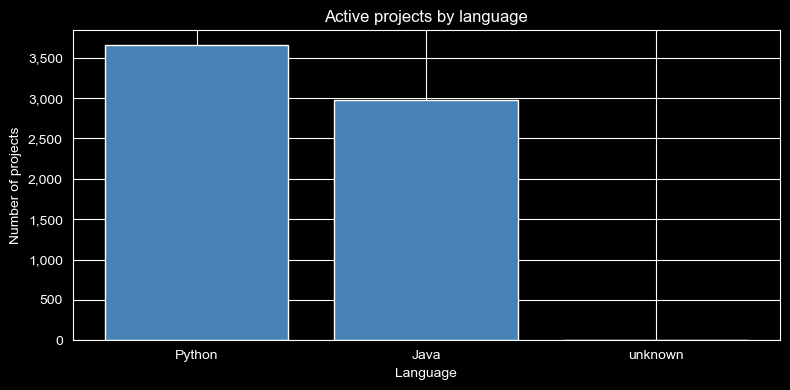

In [9]:
lang_dist = query("""
    SELECT language, COUNT(*) AS count
    FROM projects
    WHERE is_active = TRUE
    GROUP BY language
    ORDER BY count DESC
""")

display(lang_dist.style.hide(axis='index').format({'count': '{:,}'}))

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(lang_dist['language'], lang_dist['count'], color='steelblue')
ax.set_title('Active projects by language')
ax.set_xlabel('Language')
ax.set_ylabel('Number of projects')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

## 3 — Versions

In [5]:
versions_summary = query("""
    SELECT
        COUNT(*)                                    AS total_versions,
        COUNT(DISTINCT project_id)                  AS projects_with_versions,
        ROUND(AVG(cnt), 1)                          AS avg_versions_per_project,
        MAX(cnt)                                    AS max_versions_per_project
    FROM (
        SELECT project_id, COUNT(*) AS cnt
        FROM versions
        GROUP BY project_id
    ) sub
""")
display(versions_summary.style.hide(axis='index'))

/var/folders/5k/j67p1kvx0478kx8888t90bmr0000gn/T/ipykernel_27911/753284143.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(sql, conn, params=params)


total_versions,projects_with_versions,avg_versions_per_project,max_versions_per_project
6637,6637,1.000000,3


### Versions Discovered Over Time

In [ ]:
versions_over_time = query("""
    SELECT
        DATE_TRUNC('day', discovered_at)::date AS day,
        COUNT(*) AS new_versions
    FROM versions
    GROUP BY 1
    ORDER BY 1
""")

if not versions_over_time.empty:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(versions_over_time['day'], versions_over_time['new_versions'], marker='o', markersize=3)
    ax.set_title('New versions discovered per day')
    ax.set_xlabel('Date')
    ax.set_ylabel('Versions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No versions discovered yet.")

## 4 — Designite Analyses

In [ ]:
analyses_summary = query("""
    SELECT
        status,
        COUNT(*) AS count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 1) AS pct
    FROM analyses
    GROUP BY status
    ORDER BY count DESC
""")

if not analyses_summary.empty:
    display(analyses_summary.style.hide(axis='index').format({'count': '{:,}', 'pct': '{:.1f}%'}))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pie(analyses_summary['count'], labels=analyses_summary['status'],
           autopct='%1.1f%%', startangle=90)
    ax.set_title('Analysis status distribution')
    plt.tight_layout()
    plt.show()
else:
    print("No analyses run yet.")

## 5 — Quality Gate (RepoQuester)

In [ ]:
qg_summary = query("""
    SELECT
        COUNT(*)                              AS total_evaluated,
        COUNT(*) FILTER (WHERE passed)        AS passed,
        COUNT(*) FILTER (WHERE NOT passed)    AS failed,
        ROUND(AVG(score), 2)                  AS avg_score,
        MIN(score)                            AS min_score,
        MAX(score)                            AS max_score
    FROM quality_gates
""")

if qg_summary['total_evaluated'].iloc[0] > 0:
    display(qg_summary.style.hide(axis='index'))
else:
    print("No quality gates run yet.")

### Quality Gate Score Distribution

In [ ]:
score_dist = query("""
    SELECT score, COUNT(*) AS count
    FROM quality_gates
    GROUP BY score
    ORDER BY score
""")

if not score_dist.empty:
    fig, ax = plt.subplots(figsize=(7, 4))
    colors = ['tomato' if s <= 5 else 'steelblue' for s in score_dist['score']]
    ax.bar(score_dist['score'], score_dist['count'], color=colors)
    ax.axvline(x=5.5, color='black', linestyle='--', linewidth=1, label='Threshold (score > 5)')
    ax.set_title('Quality gate score distribution')
    ax.set_xlabel('Score (no. metrics > 0)')
    ax.set_ylabel('Number of projects')
    ax.set_xticks(range(0, 10))
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No quality gates run yet.")

### RepoQuester Metrics Average

In [ ]:
metrics_avg = query("""
    SELECT
        ROUND(AVG(community)::numeric, 3)               AS community,
        ROUND(AVG(continuous_integration)::numeric, 3)  AS continuous_integration,
        ROUND(AVG(documentation)::numeric, 3)           AS documentation,
        ROUND(AVG(history)::numeric, 3)                 AS history,
        ROUND(AVG(management)::numeric, 3)              AS management,
        ROUND(AVG(license)::numeric, 3)                 AS license,
        ROUND(AVG(unit_test)::numeric, 3)               AS unit_test,
        ROUND(AVG(pull)::numeric, 3)                    AS pull,
        ROUND(AVG(releases)::numeric, 3)                AS releases
    FROM quality_gates
""")

if not metrics_avg.empty and metrics_avg.notna().any(axis=1).iloc[0]:
    melted = metrics_avg.melt(var_name='metric', value_name='avg_value')
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.bar(melted['metric'], melted['avg_value'], color='mediumseagreen')
    ax.set_title('RepoQuester metrics average')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Average value')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No quality gates run yet.")